### Relatedness estimation with pc-relate, using data from malariagen_data

To start, install and import required libraries:

In [ ]:
%pip install malariagen_data scipy sgkit seaborn scikit-bio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 16.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 79.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 87.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.4/180.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.4/180.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.4/765.4 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━

In [ ]:
import malariagen_data
import numpy as np
import dask.array as da
import itertools as it
import scipy
import xarray as xr
import pandas as pd
import skbio
from geopy.distance import geodesic as GD
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import sgkit as sg
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.3.13


In [ ]:
#mount Google Drive to save data
try:
    from google.colab import drive
    drive.mount("drive")
except ImportError:
    pass

Mounted at drive


In [ ]:
#load ag3 vector data
ag3 = malariagen_data.Ag3(
    pre=True,
    results_cache="~/malariagen_data_results_cache")


This function returns a dataset with the relatedness matrix and results of a PCA. A couple of pointers:

1. If you need finer control over which data you are using, you'll need to tinker with the function arguments and corresponding arguments passed to ag3.sample_metadata and ag3.biallelic_snp_calls.


2. The recombination rate in mosquitoes is fairly similar to that in mosquitoes. This means that long recombination blocks that lead to genotypes being inherited identical-by-descent, that we use to infer relatedness, may in mosquitoes be as long as entire chromosomes. It is worthwhile running this on the whole genome (the Supplement of Eric's Nature Comms GAARD paper explains this nicely too). This function merges data from chromosomes X, 2 and 3 and runs the analysis on them.




In [ ]:
def run_pc_relate(sample_sets,
                  n_snps = 200_000,
                  max_missing_an = 1,
                  min_minor_ac=2,
                  site_mask = 'gamb_colu',
                  ):

  # Load metadata
  df_samples = ag3.sample_metadata(sample_sets=sample_sets) #metadata

  # Load SNP data
  wg_ds = ag3.biallelic_snp_calls(
      region=['2RL','3RL', 'X'],
      n_snps=n_snps,
      sample_sets=sample_sets,
      max_missing_an = 1,
      min_minor_ac=2,
      site_mask = 'gamb_colu',
  )

  # sgkit needs to have a 'call_genotype_mask' with the same dims as 'call_genotype'. Let's make a dummy one here as we've already applied site filters.
  # Create a boolean DataArray with the same dimensions, chunking, and dtype
  # NOTE - False is used to denote whether a site is masked or not, as opposed to TRUE (e.g. True if passed filter)
  boolean_array = xr.full_like(wg_ds.call_genotype, fill_value=False, dtype=bool)

  # Add the new boolean DataArray to the dataset under 'call_genotype_mask'
  wg_ds['call_genotype_mask'] = boolean_array

  # Now let's do PCA as a prelude to pc-relate
  ds_pca = sg.stats.pca.count_call_alternate_alleles(wg_ds)

  # To run PCA we need to filter out variants with any missing alt allele counts
  # Or where the counts are zero for all samples
  variant_mask = (((ds_pca.call_alternate_allele_count < 0).any(dim="samples")) | \
      (ds_pca.call_alternate_allele_count.std(dim="samples") <= 0.0)).compute()
  ds_pca = ds_pca.sel(variants=~variant_mask)

  # Now run pca
  ds_pca = sg.pca(ds_pca, algorithm='randomized', check_missing=False).compute()

  # Add arrays as vars
  ds_pca["sample_pca_projection_0"] = ds_pca.sample_pca_projection[:,0]
  ds_pca["sample_pca_projection_1"] = ds_pca.sample_pca_projection[:,1]

  # Merge metadata
  ds_annotations = pd.DataFrame.to_xarray(df_samples)
  ds_pca = ds_pca.set_index({"samples": "sample_id"})
  ds_pca = ds_pca.merge(ds_annotations, join="left")
  ds_pca = ds_pca.reset_index("samples").reset_coords(drop=True)

  ds_pca = sg.pc_relate(ds_pca) #pcrelate is supposed to account for ancestral pop structure by incorporating PCs into kinship estimation (see conomos 2016)

  return(ds_pca)

In [ ]:
sample_set = '1264-VO-CD-WATSENGA-VMF00164'

# This takes around 15-20 mins for 150k snps across two chromosomes
ds_relate = run_pc_relate(sample_sets=sample_set)

Compute SNP allele counts:   0%|          | 0/11280 [00:00<?, ?it/s]

Examine matrix plotted as heatmap


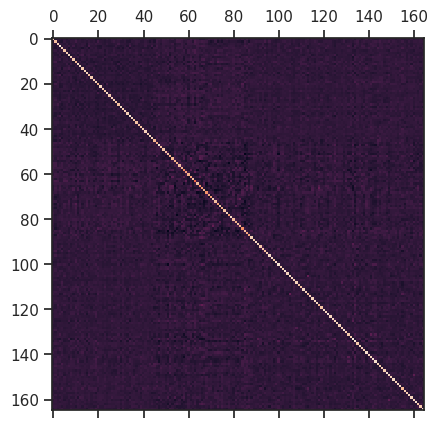

In [ ]:
plt.matshow(ds_relate.pc_relate_phi)

Let's take a look at isolation-by-distance. Ghastly function below that takes metadata dataframe and calculates a pairwise distance matrix between each level of specified factor (could be sample ID, or sampling site, state)

Make distmat by sample id. Takes a few mins.

In [ ]:
# Horrible function to calculate isolation by distance
def calculate_isolation_by_distance(ds,
                                    metadata,
                                    factor = 'sample_id', # Factor used to join metadata to dataset
                                    latcol='latitude', #lat column in metadata
                                    longcol='longitude' #long column in metadata
                                    ):

  # Calculate geographic distance between each individual
  facs = metadata[factor].unique()

  coord_df = metadata[[factor,longcol,latcol]].drop_duplicates() #make coord df

  fac_combs = pd.DataFrame(it.permutations(facs, 2), columns=[str(factor+'_a'),str(factor+'_b')]) #Make all individual combiations

  cord_intermediate = pd.merge(fac_combs, coord_df, left_on=str(factor+'_a'), right_on=factor) # On first side ('a' individuals)

  coord_combs = pd.merge(cord_intermediate, coord_df, left_on=str(factor+'_b'), right_on=factor) #On second side ('b' individuals)

  coord_combs.drop([str(factor+'_a'),str(factor+'_b')], axis=1, inplace=True)

  # Now iterate over each pair of individuals and calculate the Haversine dist between them
  distlist = []

  for i, row in coord_combs.iterrows():
      lonlat1 = (row[str(longcol+'_x')], row[str(latcol+'_x')])
      lonlat2 = (row[str(longcol+'_y')], row[str(latcol+'_y')])
      dist = GD(lonlat1, lonlat2).m
      distlist.append(dist)

  coord_combs['dist'] = distlist # Append to df

  # Make matrix of geo dist for Mantel test
  geo_dist_mat = np.array(coord_combs.pivot(index=str(factor+'_x'), columns=str(factor+'_y'),values='dist'))

  #geo_dist_mat = geo_dist_mat.fillna(0)

  np.fill_diagonal(geo_dist_mat, 'NaN')

  new_coord = coord_df.drop('sample_id', axis=1)

  # For plotting, now make long df with paired Phi and pdist in km
  relmat = np.array(ds.pc_relate_phi) # Get relmat from ds

  np.fill_diagonal(relmat, 'NaN') #

  # Now make long-form dataframe of all-sample vs all-sample relatedness
  relmdf = pd.DataFrame(relmat) # The relmat array will be used in concert with the geo_dist_mat for the Mantel test

  relmdf.columns = ds.sample_id

  relmdf["sample_id"] = ds.sample_id

  reldf = pd.melt(relmdf, id_vars='sample_id')

  reldf.columns = ['sample_a','sample_b','rxy']

  rel_intermediate = pd.merge(reldf, df_samples, left_on='sample_a', right_on='sample_id')

  rel_combs = pd.merge(rel_intermediate, df_samples, left_on='sample_b', right_on='sample_id')

  rel_combs = rel_combs[rel_combs['rxy'].notnull()]

  # Append pdist in km to longform relatedness pairwise values
  distlist = []
  for i, row in rel_combs.iterrows():
      lonlat1 = (row['longitude_x'], row['latitude_x'])
      lonlat2 = (row['longitude_y'], row['latitude_y'])
      dist = GD(lonlat1, lonlat2).km
      distlist.append(dist)

  rel_combs['geog_dist'] = distlist

  #plot
  fig = px.scatter(data_frame=rel_combs, x="geog_dist", y="rxy", opacity=0.5, hover_data=["sample_id_x", "sample_id_y","taxon_x", "taxon_y"],
                  labels={'geog_dist' : 'Distance (km)', 'rxy' : 'Kinship Coeff - φ'}, template='simple_white')
  fig.update_layout(width=800, height=800, font=dict(size = 15))

  fig.show()

  # Do Mantel test - this is a statistical test to determine correlation between two matrices.
  # We can't use a GLM for this because with lots of samples from the same site, one ends up with pseuodreplication

  # Make everything an array, fill the diagonal with zeroes
  geo_dist_mat = np.array(geo_dist_mat)
  #np.fill_diagonal(geo_dist_mat, 0)
  geo_dist_mat = geo_dist_mat.astype(float)
  #np.fill_diagonal(relmat, 0)

  rounded_arr = np.round(relmat, 10) # Round to 10 dp - relatedness estimation can result in tiny differences which throws the mantel test

  # Do and print test result
  coeff, p_value, samp = skbio.stats.distance.mantel(rounded_arr, geo_dist_mat, method='pearson', permutations=999, alternative='two-sided')

  print("The mantel coefficient is %s, and the p-value is " % coeff, p_value)


  # Return a dataframe of pairwise relatedness and pdist, relatedness and geo_dist matrices, and mantel test results
  return rel_combs, relmat, geo_dist_mat



In [ ]:
df_samples = ag3.sample_metadata(sample_sets=sample_set)

In [ ]:
rel_combs, relmat, geo_dist_mat = calculate_isolation_by_distance(ds_relate, df_samples, factor = 'sample_id', latcol='latitude', longcol='longitude')

DistanceMatrixError: Data must be symmetric and cannot contain NaNs.

In [ ]:
### MANTEL TEST HERE
# -https://scikit.bio/docs/dev/generated/skbio.stats.distance.mantel.html

In [ ]:
#coerce middle col to zero
relmat = np.array(ds_pca.pc_relate_phi)
np.fill_diagonal(relmat, 0)

relmat = np.round(relmat, 10) #round to 10 dp - relatedness estimation can result in tiny differences which throws the mantel test
coeff, p_value, samp = skbio.stats.distance.mantel(relmat, geo_dist_mat, method='pearson', permutations=999, alternative='two-sided')
print("The mantel coefficient is %s, and the p-value is " % coeff, p_value)